# How the life expectancy differs between country status and body mass index

Arial Chen\
Emily Ahn\
Karina Jhingan\
Zhekai Zhu

----------------------

## Introduction

A country's developed/developing status is mainly based on their GDP and living standards. To look at an example of how a countries status may effect it’s life expectancy: Ethiopa (a developing country) and the United States (a developed country). By comparing the living standards between Ethiopia and the US, Freeman (2020) finds out that the latter has longer life expectancy due to various factors like community-based health strategies, improving access to safe water, female education and gender empowerment, and so on. However, there is another view which deems that with the improvement of modern technology, the impact from factors like mortality has been overstated for earlier periods (Preston, 1975). This raises the question, is there a difference in life expectancy between developed and developing countries, if so is it significant? The random variable is life expectancy, the location parameter is mean, and the scale parameter is standard deviation. Our population is all countries, our dataset contains data, provided by the WHO, contains annual data observations from 2000-2015 of 193 countries. Each observation contains information on the country and year as well as socioeconomic (government spending, GDP, schooling, alcohol use) and health (BMI, immunizations, diseases) factors

## Preliminary Results

In [1]:
#Package needed in the proposal

library(cowplot)
library(digest)
library(infer)
library(repr)
library(tidyverse)
library(dplyr)
library(datateachr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



#### Load data

In [2]:
#Loading data from the Internet

life_expectancy_df <- read.csv(file = 'https://raw.githubusercontent.com/eahn01/stat201-group25/main/data/life-expectancy.csv')

#Overview of the dataframe

head(life_expectancy_df)

,Country,Year,Status,Life.expectancy,Adult.Mortality,infant.deaths,Alcohol,percentage.expenditure,Hepatitis.B,Measles,⋯,Polio,Total.expenditure,Diphtheria,HIV.AIDS,GDP,Population,thinness..1.19.years,thinness.5.9.years,Income.composition.of.resources,Schooling
,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,⋯,6,8.16,65,0.1,584.25921,33736494,17.2,17.3,0.479,10.1
2,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,⋯,58,8.18,62,0.1,612.69651,327582,17.5,17.5,0.476,10.0
3,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,⋯,62,8.13,64,0.1,631.74498,31731688,17.7,17.7,0.470,9.9
4,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,⋯,67,8.52,67,0.1,669.95900,3696958,17.9,18.0,0.463,9.8
5,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,⋯,68,7.87,68,0.1,63.53723,2978599,18.2,18.2,0.454,9.5
6,Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,⋯,66,9.20,66,0.1,553.32894,2883167,18.4,18.4,0.448,9.2


#### Clean and wrangle data

The original data frame is in tidy format, so we only need to select the columns needed, which are country, year, status, life expectnacy. Then, we also remove the N\A values since N\A values are useless in statistical inference.

In [3]:
# Dataframe of developing countries and developed countries, with columns needed, N/A removed.

life <- life_expectancy_df%>%
                 filter(!is.na(Life.expectancy))%>%
                 filter(!is.na(BMI))%>%
                 select(Country,Year,Status, Life.expectancy,BMI)

#Add a new column indicating the bmi level (3 levels: low, standard, high)

life$BMI_Level <- with(life, ifelse(BMI > 30, 'Super High',
                                       ifelse(BMI > 25, 'High',
                                       ifelse(BMI > 18.5,'Standard','Low'))))

#### Final dataframe

In [4]:
#Overview of the dataframe

head(life)

#Number of observations (rows)

nrow(life)

,Country,Year,Status,Life.expectancy,BMI,BMI_Level
,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>
1,Afghanistan,2015,Developing,65.0,19.1,Standard
2,Afghanistan,2014,Developing,59.9,18.6,Standard
3,Afghanistan,2013,Developing,59.9,18.1,Low
4,Afghanistan,2012,Developing,59.5,17.6,Low
5,Afghanistan,2011,Developing,59.2,17.2,Low
6,Afghanistan,2010,Developing,58.8,16.7,Low


[1] 2896

#### Visualization of data

In this part, we use plots to show relevant statistics, which allows us to visualize the data information.

In [5]:
# The configurations of plots

options(repr.plot.width = 15, repr.plot.height = 8.5)

plot_config1 <- theme_classic() +
                theme(plot.title = element_text(hjust = 0.5),
                      legend.position="none",
                      panel.spacing = unit(50, "lines"),
                      strip.text.x = element_text(size = 8),
                      panel.spacing.x = unit(50, "cm"),
                      text = element_text(size = 20))

for_loop_function_each_year <- c("2000", "2001", "2002", "2003", "2004","2005","2006","2007","2008","2009","2010")

year_labels_for_each_years<-c("2000", "2001", "2002", "2003", "2004","2005","2006","2007","2008","2009","2010")
                      
boxplot_scale <- scale_y_continuous(breaks = seq(0, 100, 10))

bmi_labels <- scale_x_discrete(labels = c("low", "mid","high"))

In [14]:
#Life expectancy distribution for all countries in each year

plot_each_year <- function(i)
  {plot<-
       life %>%
       filter(Year == for_loop_function_each_year[i])%>%
       ggplot(aes(x = Life.expectancy)) +
       geom_histogram(binwidth = 1) +
       xlab("Life expectancy (in years)") +
       ylab("Count") 
  
  return(plot)}

P2000<-plot_each_year(1)
P2001<-plot_each_year(2)
P2002<-plot_each_year(3)
P2003<-plot_each_year(4)
P2004<-plot_each_year(5)
P2005<-plot_each_year(6)
P2006<-plot_each_year(7)
P2007<-plot_each_year(8)
P2008<-plot_each_year(9)
P2009<-plot_each_year(10)
P2010<-plot_each_year(11)

Plot_of_each_year<-plot_grid(P2000,P2001,P2002,P2003,P2004,P2005,P2006,P2007,P2008,P2009,P2010,ncol=5,labels=year_labels_for_each_years,hjust=-3.5,label_colour = "red")

#Life expectancy distribution for all countries in all years

All_countries_dis <- life %>% 
    group_by(Country) %>% 
    summarize(mean_life_expectancy = mean(Life.expectancy)) %>% 
        ggplot(aes(x = mean_life_expectancy)) +
        geom_histogram(binwidth = 3, colour = "white") +
        xlab("Life Expectancy (in years)") +
        ggtitle("Distribution of mean life expectancy for each country")+
        plot_config1


#Boxtplot for 2 country status

Boxplot_Country_Status <- life %>%
    ggplot(aes(x = Status, y = Life.expectancy, color = Status)) +
    geom_boxplot() +
    xlab("2 levels of Country Status") +
    ylab("Life expectancy (in years)") +
    ggtitle("Life expectancy Based on Country Status") +
    plot_config1 +
    boxplot_scale

#Boxplot for each levels of bmi

Boxplot_BMI_Level <- life %>%
    ggplot(aes(x = BMI_Level, y = Life.expectancy, color = BMI_Level)) +
    geom_boxplot() +
    xlab("3 levels of BMI") +
    ylab("Life expectancy (in years)") +
    ggtitle("Life expectancy Based on BMI Level") +
    plot_config1 +
    boxplot_scale

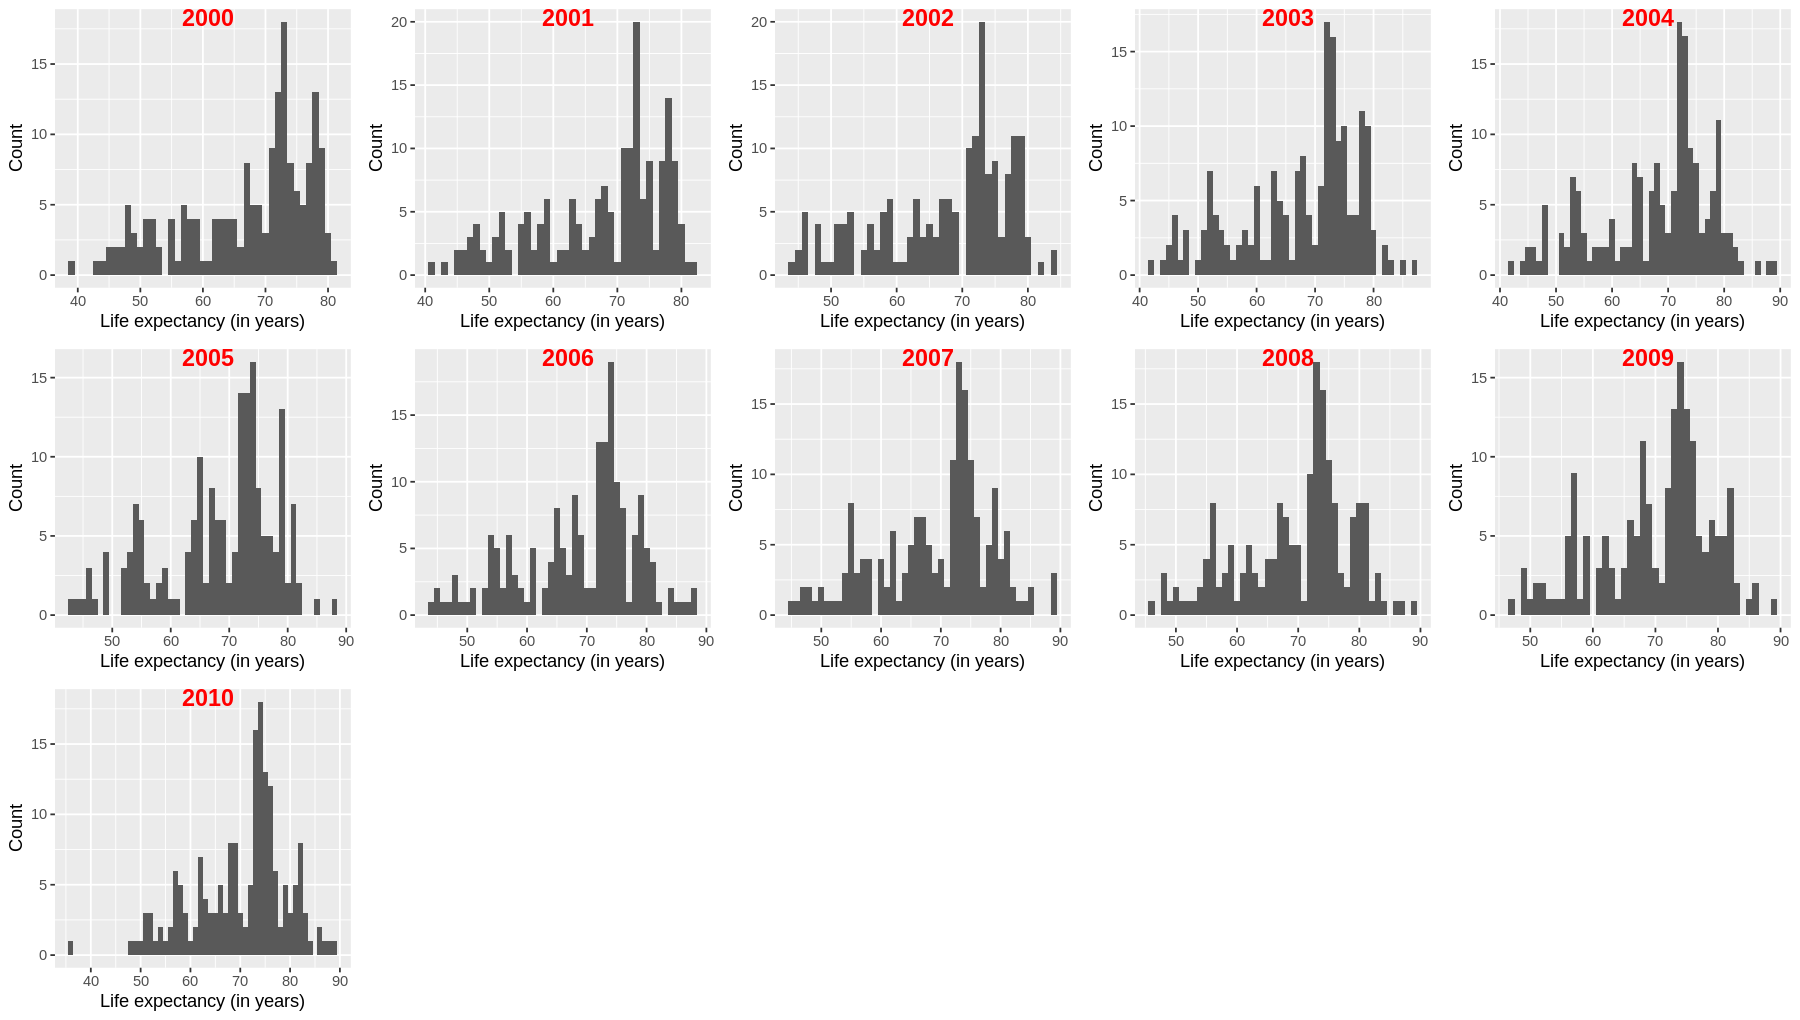

In [15]:
Plot_of_each_year

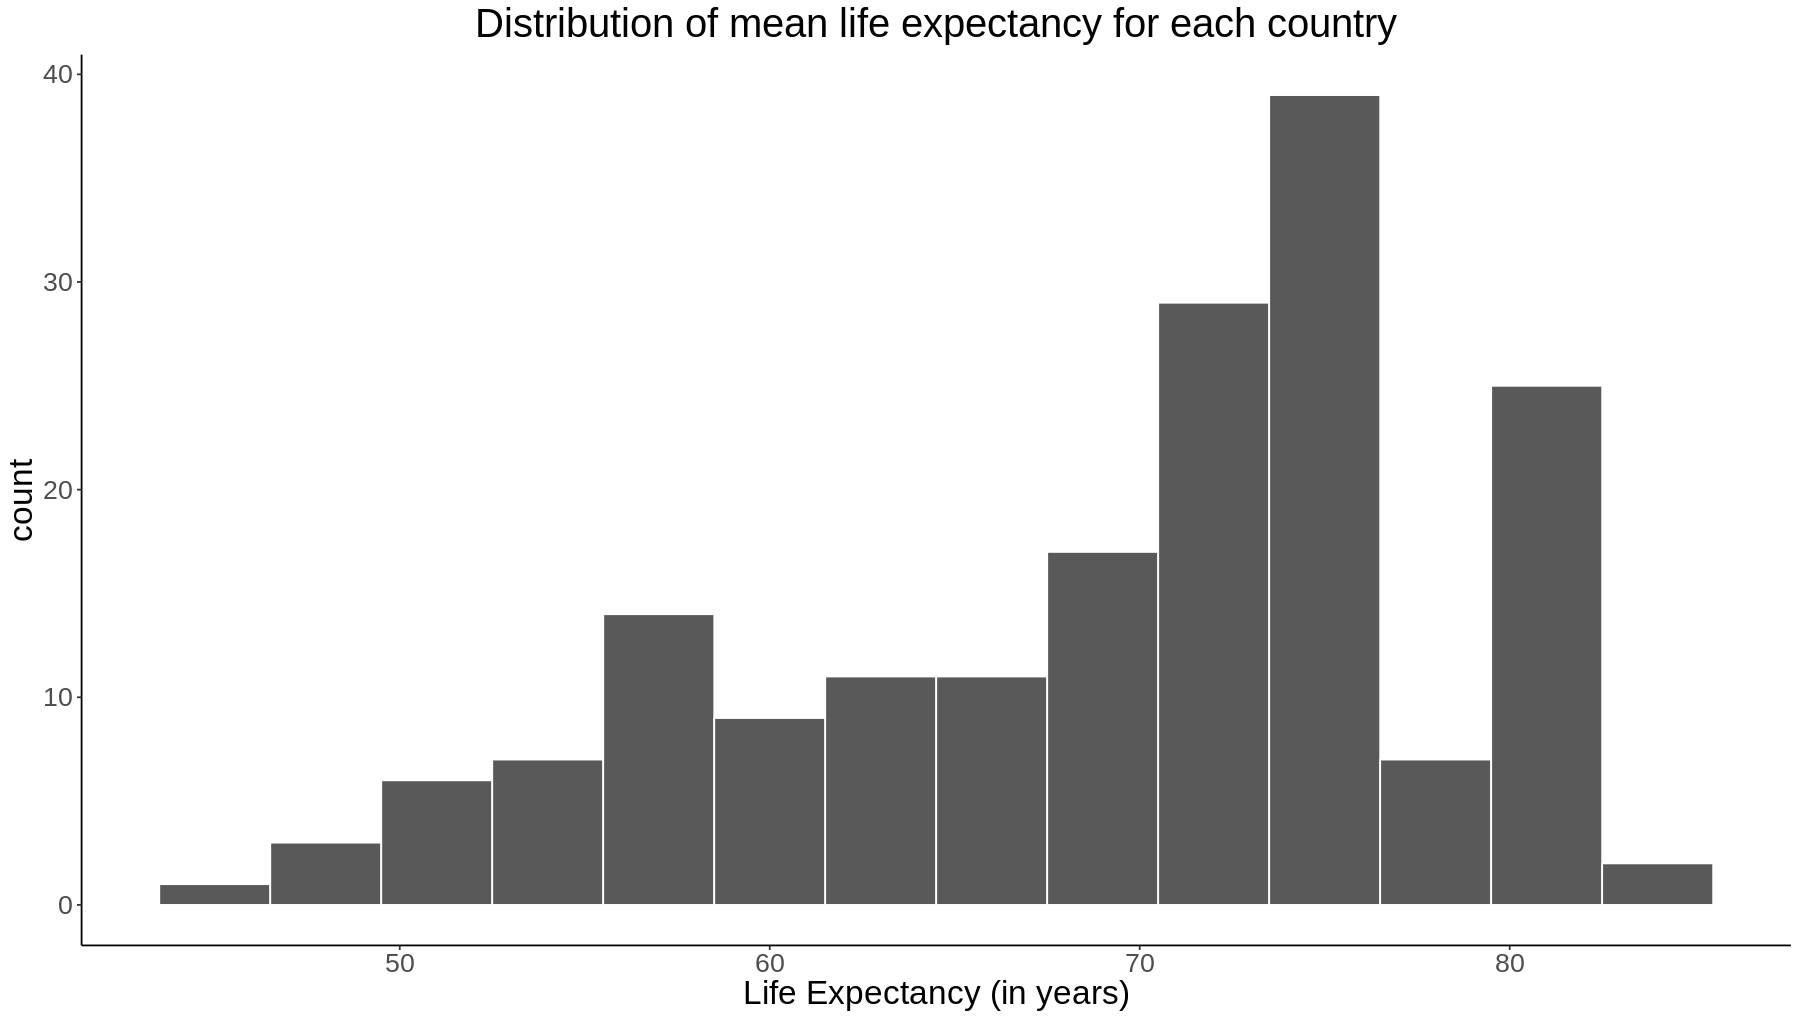

In [16]:
All_countries_dis

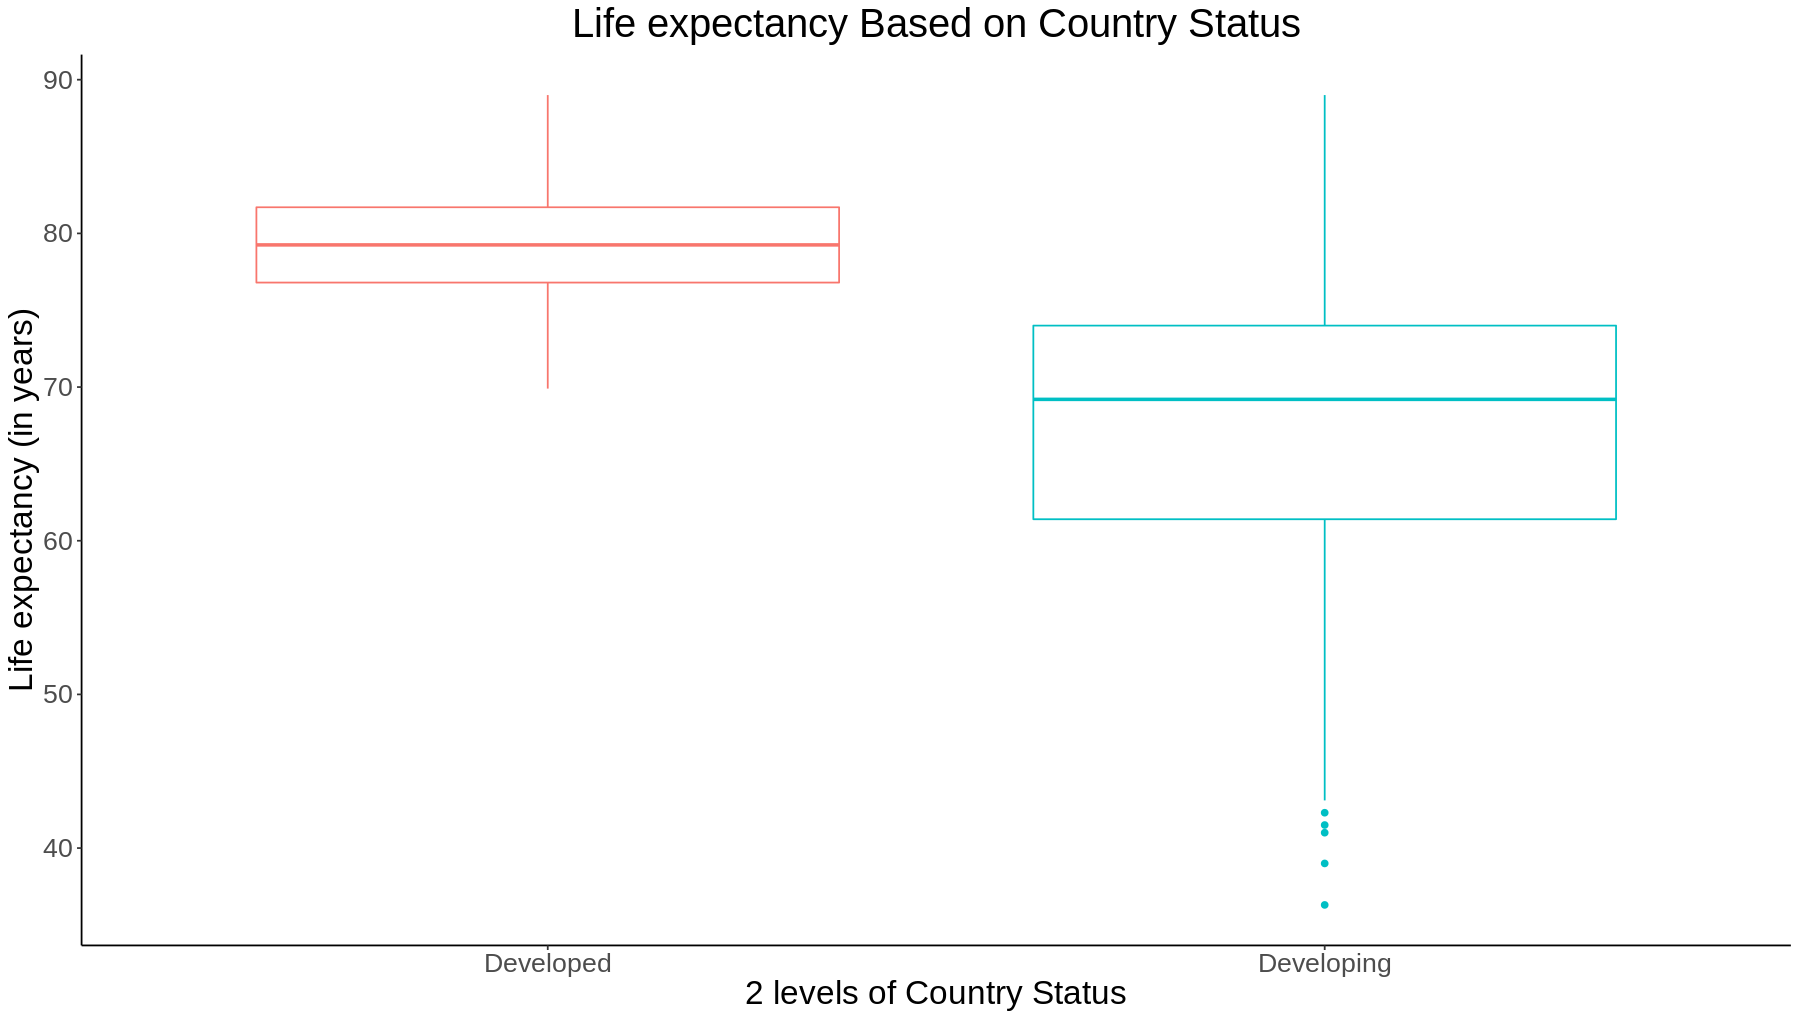

In [17]:
Boxplot_Country_Status

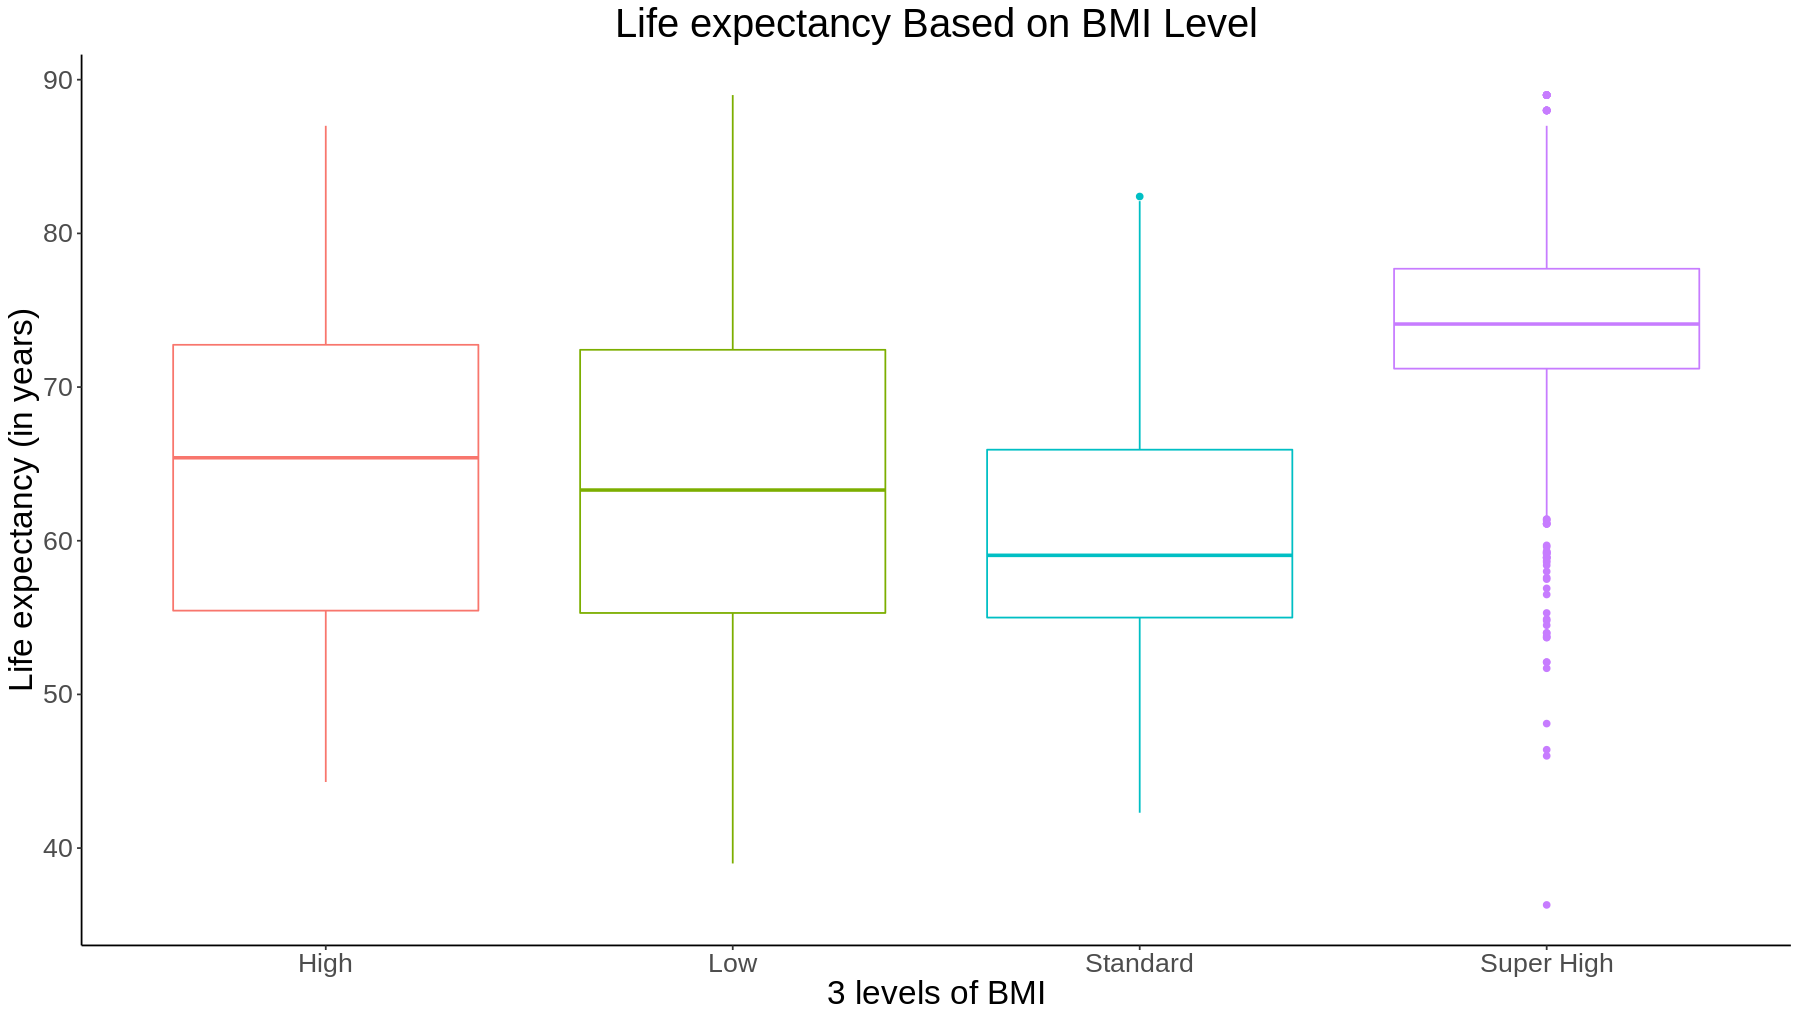

In [18]:
Boxplot_BMI_Level

#### Statistics of Dataset

In [27]:
#Mean and standard deviation of life expectancy for developing countries and developed countries

STAT_Country_Status<- life %>%
    group_by(Status) %>%
    summarise(status_mean_life = mean(Life.expectancy),
              status_sd_life = sd(Life.expectancy))

STAT_Country_Status

Status,status_mean_life,status_sd_life
<chr>,<dbl>,<dbl>
Developed,79.19785,3.930942
Developing,67.23578,8.985598


In [24]:
#Mean and standard deviation of life expectancy for people in 4 levels of BMI
STAT_BMI_Level<- life %>%
    group_by(BMI_Level) %>%
    summarise(BMI_mean_life = mean(Life.expectancy),
              BMI_sd_life = sd(Life.expectancy))

STAT_BMI_Level

BMI_Level,BMI_mean_life,BMI_sd_life
<chr>,<dbl>,<dbl>
High,64.28994,11.345712
Low,63.51692,10.125078
Standard,60.47317,7.902058
Super High,73.83324,5.962705


#### Visualization of the statistics

In [35]:
vis_stat_status<- STAT_Country_Status %>%
    ggplot(aes(x = Status, y = status_mean_life, fill = Status)) +
    geom_bar(stat = "identity") +
    xlab("Country status") +
    ylab("Mean life expectancy") +
    ggtitle("Mean life expectancy for 2 levels of country status") +
    plot_config1

vis_stat_BMI<- STAT_BMI_Level %>%
    ggplot(aes(x = BMI_Level, y = BMI_mean_life, fill = BMI_Level)) +
    geom_bar(stat = "identity") +
    xlab("4 levels of BMI") +
    ylab("Mean life expectancy") +
    ggtitle("Mean life expectancy for 2 levels of country status") +
    plot_config1

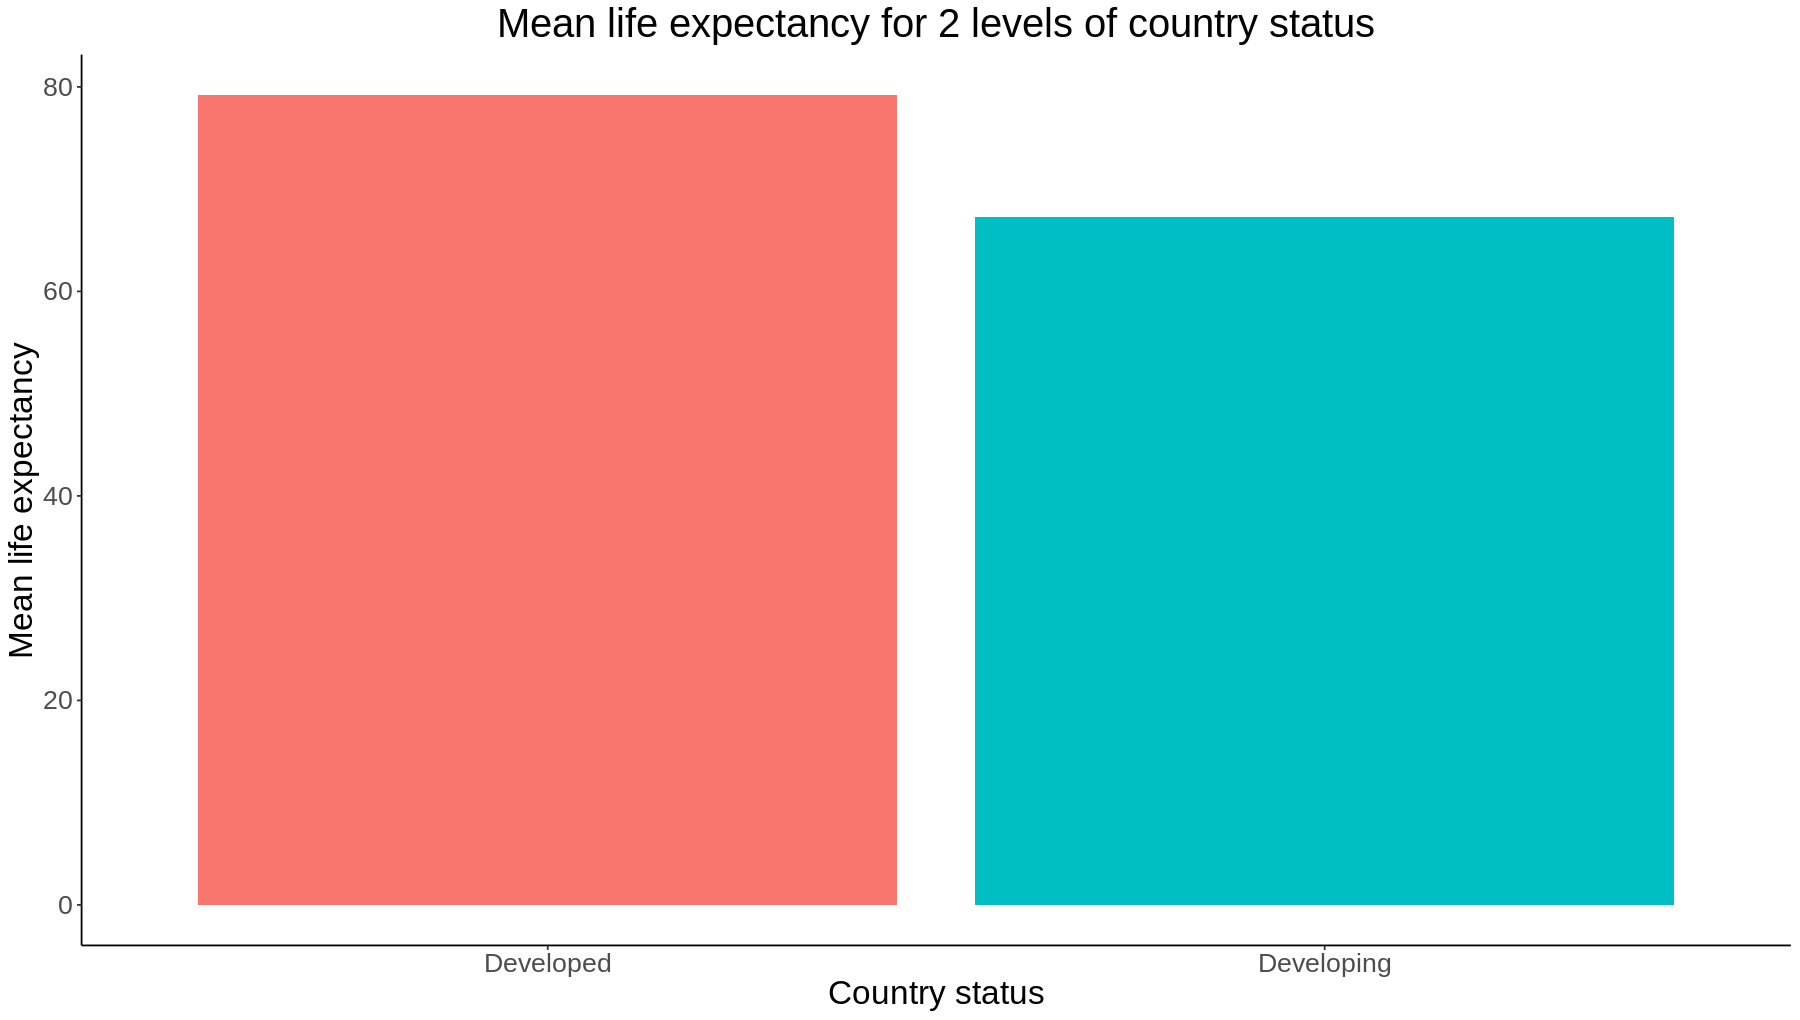

In [36]:
vis_stat_status

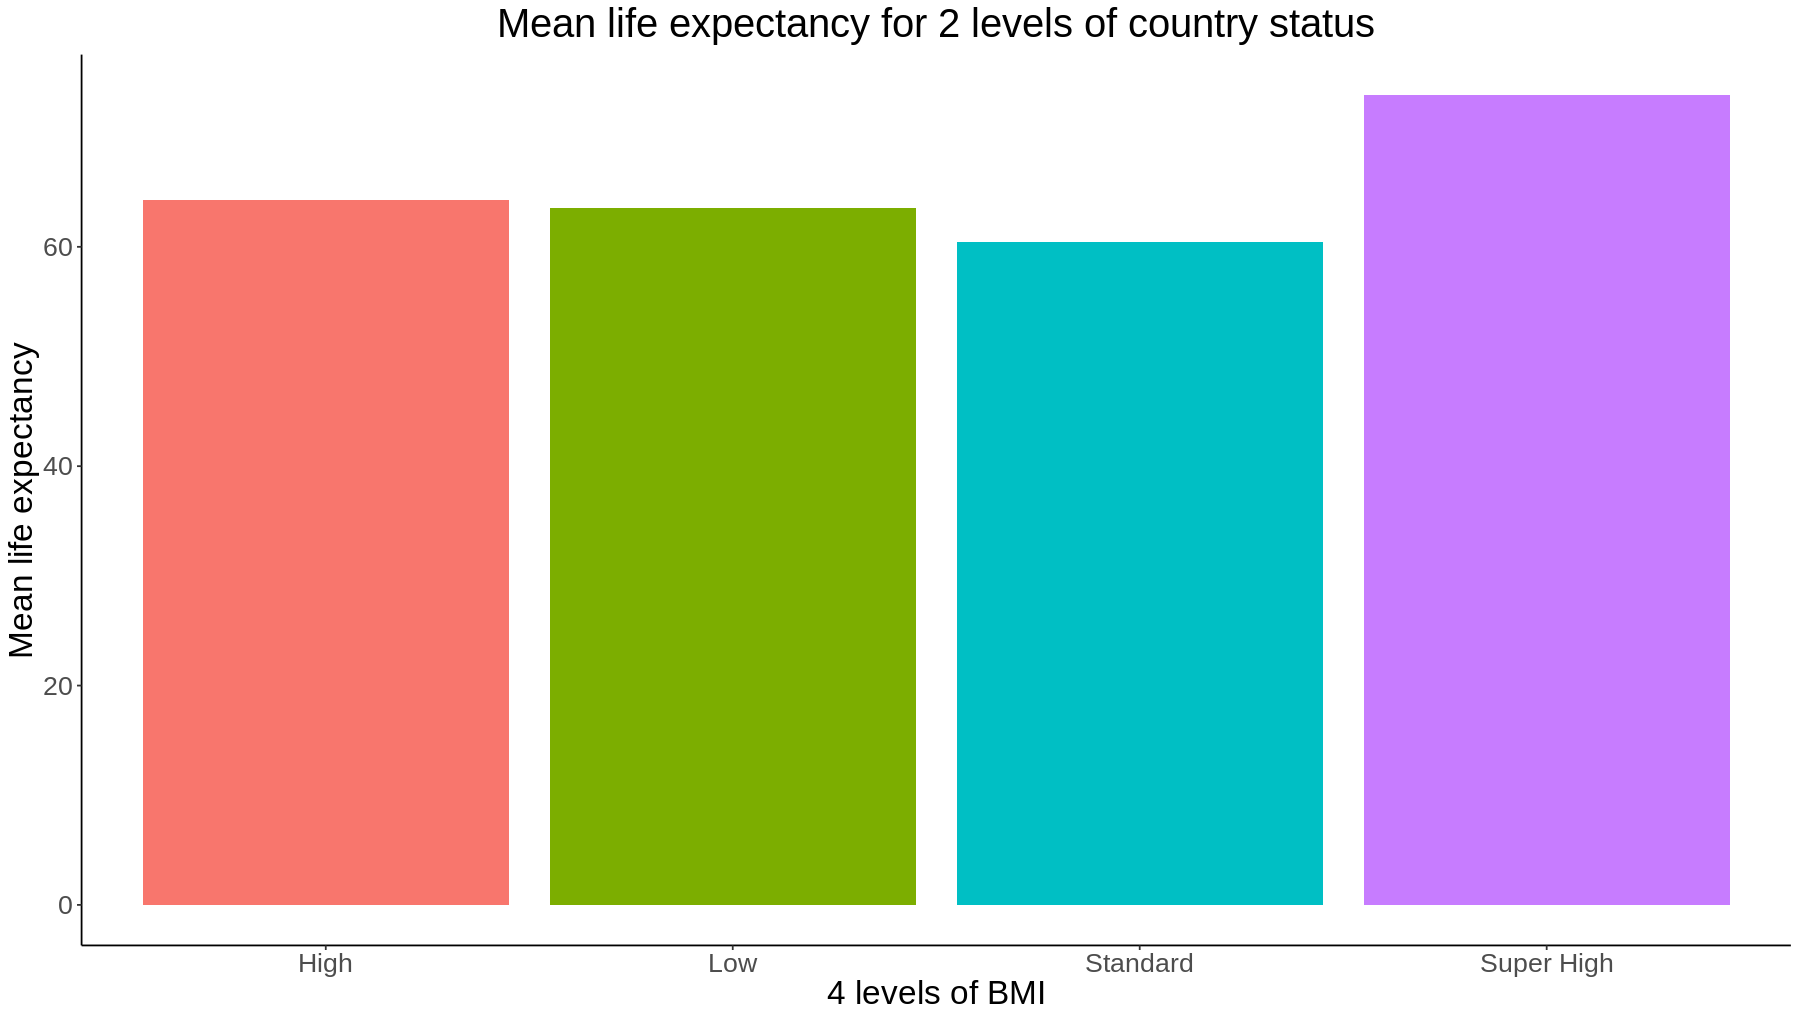

In [37]:
vis_stat_BMI

## Method: Plan

We are expected to find the life expectancy in developed countries is greater than developing countries by implying hypothesis test and bootstrapping. Our findings would indicate a level of correlation between the condition of the national economy and lifespan. A later study could look into what ae the differences are between developing countries and developed countries that lead to the different length of life, and how do these factors affect the length of life.

## References

* Freeman, T., Gesesew, H. A., Bambra, C., Giugliani, E. R. J., Popay, J., Sanders, D., ... & Baum, F. (2020). Why do some countries do better or worse in life expectancy relative to income? An analysis of Brazil, Ethiopia, and the United States of America. International journal for equity in health, 19(1), 1-19.

* Preston, S. H. (1975). The changing relation between mortality and level of economic development. Population studies, 29(2), 231-248.